In [8]:
import os
import random
import pandas as pd
import datetime
import numpy as np
from sklearn.preprocessing import LabelEncoder
from etl.data_processor_old import FeatureProcessor, VERB_MAP, OBSERVABLE
import tensorflow as tf
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ROOT_DATA_PATH = "../data/raw/"

In [9]:
data_a_train = pd.read_csv(os.path.join(ROOT_DATA_PATH, "data_a_train.csv"))
data_a_train[OBSERVABLE] = data_a_train[OBSERVABLE].apply(
    lambda x: VERB_MAP[x] if x in VERB_MAP else x
)
data_a_hidden = pd.concat(
    [
        pd.read_csv(os.path.join(ROOT_DATA_PATH, "data_a_hidden_10.csv")),
        pd.read_csv(os.path.join(ROOT_DATA_PATH, "data_a_hidden_20.csv")),
        pd.read_csv(os.path.join(ROOT_DATA_PATH, "data_a_hidden_30.csv")),
    ],
    axis=0,
    sort=False
)
data_a_hidden[OBSERVABLE] = data_a_hidden[OBSERVABLE].apply(
    lambda x: VERB_MAP[x] if x in VERB_MAP else x
)
verb_ln = LabelEncoder()
verb_ln.fit(data_a_train["Observable"].tolist() + data_a_hidden["Observable"].tolist())
hidden_index, hidden = FeatureProcessor().get_multi_dim_verb(data_a_hidden)
train_index, train = FeatureProcessor().get_multi_dim_verb(data_a_train)
verb_ln.fit(list(hidden[:, :, 3].ravel())+list(train[:, :, 3].ravel()))
hidden[:, :, 3] = verb_ln.transform(hidden[:, :, 3].ravel()).reshape(hidden[:, :, 3].shape)
train[:, :, 3] = verb_ln.transform(train[:, :, 3].ravel()).reshape(train[:, :, 3].shape)
label = pd.read_csv(os.path.join(ROOT_DATA_PATH, "data_train_label.csv")).set_index("STUDENTID")
label = label.reindex(train_index)
train = train.astype(np.int32)
hidden = hidden.astype(np.int32)

In [10]:
# print(train[0, :, 3])
# print(verb_ln.inverse_transform(train[0, :, 3]))
print(train.shape)
print(label.shape)
print(hidden.shape)
zip_combine = list(zip(label.values, train))
random.shuffle(zip_combine)
label_values, train = zip(*zip_combine)
train = np.array(train)
label_values = np.array(label_values).astype(int)
tmp_train = np.zeros(hidden.shape)
tmp_train[0: train.shape[0], 0: train.shape[1], 0: train.shape[2]] = train
train = tmp_train 
print(train.shape)
print(hidden.shape)
print(train[:, :, 0].shape)
# custom metric with TF

def cohens_kappa(y_true, y_pred):
    return tf.contrib.metrics.cohen_kappa(tf.round(y_true), tf.round(y_pred), 2)[1]

(1232, 33, 4)
(1232, 1)
(1232, 54, 4)
(1232, 54, 4)
(1232, 54, 4)
(1232, 54)


In [11]:
# duration_level_input = tf.keras.layers.Input(shape=(train.shape[1], 1))
# verb_count_input = tf.keras.layers.Input(shape=(train.shape[1], 1))
# unique_verb_count_input = tf.keras.layers.Input(shape=(train.shape[1], 1))
verb_input = tf.keras.layers.Input(shape=(train.shape[1],))
# duration_level_normalize = tf.keras.layers.BatchNormalization()(duration_level_input)
# verb_count_normalize = tf.keras.layers.BatchNormalization()(verb_count_input)
# unique_verb_normalize = tf.keras.layers.BatchNormalization()(unique_verb_count_input)
verb_embedding = tf.keras.layers.Embedding(
    output_dim=10, 
    input_dim=len(verb_ln.classes_)+1, 
    input_length=train.shape[1],
)(verb_input)
# merged_input = tf.keras.layers.concatenate(
#     [duration_level_normalize, verb_count_normalize, unique_verb_normalize, verb_embedding],
#     axis=-1
# )
# input_dropout = tf.keras.layers.Dropout(0.2)(merged_input)
# lstm = tf.keras.layers.Bidirectional(
#     tf.keras.layers.LSTM(
#         10, 
#         dropout=0.3,
#         kernel_initializer=tf.keras.initializers.VarianceScaling(),
#         recurrent_initializer='orthogonal',
#         bias_initializer='random_uniform',
#         )
# )(merged_input)
input_ = tf.keras.layers.Input(shape=(train.shape[1], train.shape[2]-1))
normalize_input = tf.keras.layers.BatchNormalization()(input_)
merged_input = tf.keras.layers.concatenate(
    [normalize_input, verb_embedding],
    axis=-1
)
conv1d_1 = tf.keras.layers.Conv1D(100, 15, activation='relu', name="conv1d_1", input_shape=(train.shape[1], train.shape[2]))(merged_input)
conv1d_2 = tf.keras.layers.Conv1D(100, 10, activation='relu')(conv1d_1)
max_pool = tf.keras.layers.MaxPooling1D(3)(conv1d_2)
conv1d_3 = tf.keras.layers.Conv1D(100, 3, activation='relu')(max_pool)
conv1d_4 = tf.keras.layers.Conv1D(100, 6, activation='relu')(conv1d_3)
max_pool_2 = tf.keras.layers.MaxPooling1D(3)(conv1d_4)
conv1d_5 = tf.keras.layers.Conv1D(100, 1, activation='relu')(max_pool_2)
conv1d_6 = tf.keras.layers.Conv1D(100, 1, activation='relu')(conv1d_5)
gloable_average = tf.keras.layers.GlobalAveragePooling1D()(conv1d_6)
dropout = tf.keras.layers.Dropout(0.5)(gloable_average)
# lstm = tf.keras.layers.LSTM(
#         50, 
#         dropout=0.8,
#         # kernel_initializer=tf.keras.initializers.VarianceScaling(),
#         # recurrent_initializer='orthogonal',
#         # bias_initializer='random_uniform',
# )(verb_embedding)
dense = tf.keras.layers.Dense(
    50, 
    activation='relu',
    # kernel_initializer=tf.keras.initializers.VarianceScaling(),
    # bias_initializer='random_uniform',
    )(dropout)
flatten = tf.keras.layers.Flatten()(dense)
# output = tf.keras.layers.Dense(
#     1, 
#     activation='sigmoid', 
#     # kernel_initializer=tf.keras.initializers.VarianceScaling(),
#     # bias_initializer='random_uniform',
#     )(flatten)
output = tf.keras.layers.Dense(
    1, 
    activation='sigmoid'
    )(dropout)
model = tf.keras.Model(
    inputs=[input_, verb_input],
    outputs=output
)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00005
)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['acc', tf.keras.metrics.AUC(), cohens_kappa]
)
print(model.summary())
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 54, 3)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 54, 3)        12          input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 54, 10)       19430       input_3[0][0]                    
____________________________________________________________________________________________

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_graph=True,
    write_grads=True,
    write_images=False,
    update_freq="epoch"
)

In [14]:
# print(label_values.shape, sum(label_values))
tf.keras.backend.get_session().run(tf.local_variables_initializer())
history = model.fit(
    [train[:, :, :3], train[:, :, 3]], 
    label_values,
    # batch_size=100,
    shuffle = True,
    epochs=20,
    validation_split=0.2,
    # callbacks=[tf.keras.callbacks.EarlyStopping("loss", 50)]
)

Train on 985 samples, validate on 247 samples
Epoch 1/20
985/985 [==============================] - 1s 855us/sample - loss: 0.4929 - acc: 0.7848 - auc_1: 0.8534 - cohens_kappa: 0.5680 - val_loss: 0.5438 - val_acc: 0.7530 - val_auc_1: 0.8013 - val_cohens_kappa: 0.5259
Epoch 2/20
985/985 [==============================] - 1s 918us/sample - loss: 0.4758 - acc: 0.7868 - auc_1: 0.8698 - cohens_kappa: 0.5170 - val_loss: 0.5355 - val_acc: 0.7409 - val_auc_1: 0.8041 - val_cohens_kappa: 0.5207
Epoch 3/20
985/985 [==============================] - 1s 1ms/sample - loss: 0.4547 - acc: 0.8081 - auc_1: 0.8850 - cohens_kappa: 0.5251 - val_loss: 0.5622 - val_acc: 0.7085 - val_auc_1: 0.8054 - val_cohens_kappa: 0.5314
Epoch 4/20
985/985 [==============================] - 1s 1ms/sample - loss: 0.4466 - acc: 0.7959 - auc_1: 0.8860 - cohens_kappa: 0.5285 - val_loss: 0.5414 - val_acc: 0.7287 - val_auc_1: 0.8011 - val_cohens_kappa: 0.5261
Epoch 5/20
985/985 [==============================] - 1s 1ms/sample - 

In [17]:
hidden_label = pd.read_csv(os.path.join("../data/raw/", "hidden_label.csv"))
hidden_result = model.predict([hidden[:, :, :3], hidden[:, :, 3]])
hidden_result_value = hidden_result.ravel()
print(hidden_result_value)
predict_result = pd.DataFrame(hidden_result_value, index=hidden_index).reindex(hidden_index)
print(predict_result)

[0.0703418  0.03182328 0.6542592  ... 0.7015476  0.05492359 0.05612719]
                   0
2333000106  0.070342
2333000190  0.031823
2333000289  0.654259
2333000386  0.226941
2333000637  0.054330
...              ...
2333383927  0.043874
2333384672  0.645323
2333384869  0.701548
2333385024  0.054924
2333385181  0.056127

[1232 rows x 1 columns]


In [19]:
print(hidden_result.ravel())
hidden_result_value = hidden_result.ravel()
predict_result = pd.DataFrame(hidden_result_value, index=hidden_index).reindex(hidden_index)
print(predict_result)
predict_result.to_csv(
    "result2.csv",
    line_terminator=",\n",
    index=False,
    header=False
)

[0.0703418  0.03182328 0.6542592  ... 0.7015476  0.05492359 0.05612719]
                   0
2333000106  0.070342
2333000190  0.031823
2333000289  0.654259
2333000386  0.226941
2333000637  0.054330
...              ...
2333383927  0.043874
2333384672  0.645323
2333384869  0.701548
2333385024  0.054924
2333385181  0.056127

[1232 rows x 1 columns]


In [34]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

[0.48402947, 0.6142506, 0.61916465, 0.61916465, 0.61916465, 0.6167076, 0.61916465, 0.61916465, 0.6167076, 0.61916465, 0.6216216, 0.6216216, 0.6216216, 0.61916465, 0.6216216]


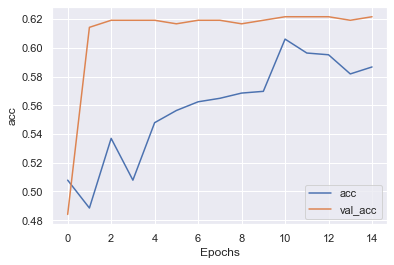

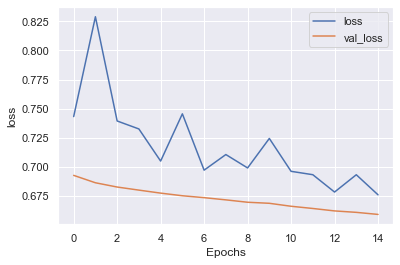

KeyError: 'auc_1'

In [61]:
print(history.history['val_acc'])
plot_graphs(history, 'acc')

plot_graphs(history, 'loss')
plot_graphs(history, 'auc_1')
plot_graphs(history, 'cohens_kappa')

(1232,) (1232,) (1232,)
(1232, 4) 1232


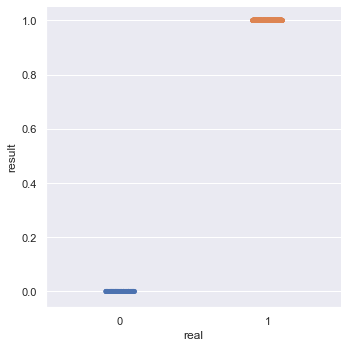

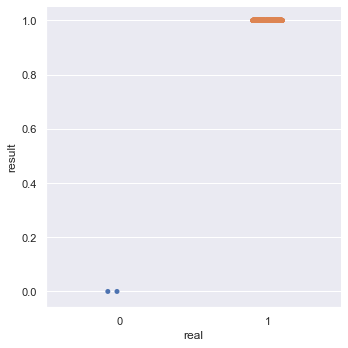

In [94]:
with open("result.csv", "r") as f:
    result_30 = np.array([float(x) for x in f.readlines(1)[0].split(",")[:-1]])
result_10 = predict_result.values.ravel()
values = label_values.ravel()
print(result_30.shape, result_10.shape, values.shape)
result_10_df = pd.DataFrame({
    "student": hidden_index,
    "result": result_10,
    "real": values
})
result_10_df.loc[result_10_df["result"] > 0.5, :] = 1
result_10_df.loc[result_10_df["result"] <= 0.5, :] = 0
result_30_df = pd.DataFrame({
    "student_df": hidden_index,
    "result": result_30,
    "real": values
})
result_30_df.loc[result_30_df["result"] > 0.5, :] = 1
result_30_df.loc[result_30_df["result"] <= 0.5, :] = 0
result_10_df["type"] = (result_10_df["result"] == result_10_df["real"])
result_30_df["type"] = (result_30_df["result"] == result_30_df["real"])
g = sns.catplot(x="real", y="result", data=result_10_df)
k = sns.catplot(x="real", y="result", data=result_30_df)
result_10_df.describe()
print(result_10_df.shape, result_10_df["type"].sum())